# Reconstruction of the age-metallicity relation based on the JJ model and the APOGEE Red Clump sample

In this tutorial, we constrain the shape of the age-metallicity relation (AMR) 
at the different Galactocentric distances using the APOGEE Red Clump (RC) sample.
The approach is described in Sysoliatina and Just (2021), here is a short summary:

   (1) Get the APOGEE RC DR16 catalogue, separate high- and low-alpha populations and calculate 
       cumulative metallicity distribution functions (CMDFs). For the low-alpha population 
       CMDF is calculated in the different radial bins, for the high-alpha population no R-binning 
       is applied as the population is well-mixed (chemically homogeneous). 
  
   (2) Assuming initial AMR, use the the JJ model to derive vertical potential and density at each 
       R and model RC cumulative age distribution functions (CADFs).
 
   (3) By comparing CMDFs to CADFs (low-alpha = thin disk, high-alpha = thick disk),
       get the updated thin- and thick-disk AMR. Iterate over steps (2)-(3) until the new AMR converges 
       to a constant shape (~3-5 iterations). 
       
   (4) Fit the derived AMR with an analytic function. In case of the thin disk, best AMR parameters are then  
       fitted with simple radial laws, and thus a 'global' analytic AMR is obtained.
       
   (5) Perform a consistency test: calculate metallicty distributions for the thin and thick disk 
       using the derived AMR and compare them to the data. 
       
This notebook includes steps (1)-(3). 


In [1]:
import os
import urllib
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from astropy.table import Table
from jjmodel.input_ import p, a, inp
from jjmodel.constants import tp,tr
from jjmodel.tools import Timer, rebin_histogram
from jjmodel.iof import tab_reader, dir_tree
from jjmodel.funcs import IMF, SFR, AMR
from jjmodel.mwdisk import disk_builder
from jjmodel.populations import stellar_assemblies_r
from jjmodel.analysis import GetPopulations, agehist, rhoz_monoage, methist
from jjmodel.plotting import Plotting
from jjmodel.transform import XVTrans

dir_tree(p,make=True)     # Create output directory for plots and tables
fnt1, fnt2 = 16, 12       # Font size for plotting

label_size = 14
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 



Parameter file(s) : ok.
Number of parameters =  71 , among them technical =  7

 p(run_mode=1, out_dir='tutorial4_model+zw_newfit_dm', out_mode=1, nprocess=4, Rsun=8.17, zsun=20, Vsun=12.5, Rmin=4.5, Rmax=13.5, dR=1.0, zmax=2000, dz=2, Rd=2.5, Rt=2.0, Rg1=3.0, Rg2=10, Rg10=4.0, Rg20=4.0, Rdf=9, Rf=100, a_in=-2.5, Mb=8000000000.0, sigmad=29.4, sigmat=4.9, sigmag1=1.7, sigmag2=10.9, sigmadh=51.9, sigmash=0.47, td1=0, td2=7.8, dzeta=0.83, eta=5.6, pkey=0, k_td2=1.5, k_dzeta=0.18, k_eta=-0.1, tt1=0.1, tt2=4, gamma=2, beta=3.5, imfkey=0, a0=1.31, a1=1.5, a2=2.88, a3=2.28, m0=0.49, m1=1.43, m2=6.0, fehkey=0, FeHd0=-0.7, FeHdp=0.29, rd=0.34, q=-0.72, k_FeHd0=-0.025, k_FeHdp=-0.0875, k_rd=0.005, k_q=-0.03, dFeHdt=0, n_FeHdt=1, FeHt0=-0.94, FeHtp=0.04, rt=0.77, t0=0.97, FeHsh=-1.5, dFeHsh=0.4, n_FeHsh=7, alpha=0.409, sige=25.1, sigt=43.3, sigdh=140, sigsh=100)

Parameters checked: 0 Reminders, 0 Warnings, 0 Errors.

Configuration finished:  0h 0m 0.42s
Results of this run will be saved to alre

## Step 1. CMDFs from the APOGEE RC data

Read the catalogue and split it into high- and low-alpha populations. 
Note, that the definition of the boundary between high- and low-alpha populations differs 
from the one given by Eq.6 in Sysoliatina and Just (2021) as the calibrations 
of DR16 (here) and DR14 (used in the paper) are somewhat different.

Galactocentric R and z in the RC catalogue are calculated assuming R0 = 8.15 kpc and Z0 = 20.8 pc
from Bennett and Bovy (2019) (https://data.sdss.org/datamodel/files/APOGEE_RC/cat/apogee-rc-DR16.html). 
This is very close to the values we assume in the JJ model (see parameter file), but for the sake of consistency
we calculate R and z for our parameters and use these new columns to select RC stars. 

We interpret the upper part of the derived CMDFs as a convolution of a true linear trend and a Gaussian kernel 
representing an error model (deviation from the linear trend in a broad sense - due to systematic errors at high
metallicities or presence of migrated stars). In this analysis, we use CMDFs with the reconstructed linear 
upper parts. 


In [2]:
# Download APOGEE RC DR16 catalogue to the current directory (259.6 MB)

urllib.request.urlretrieve('https://data.sdss.org/sas/dr16/apogee/vac/apogee-rc/cat/apogee-rc-DR16.fits',
                           "apogee-rc-DR16.fits")


('apogee-rc-DR16.fits', <http.client.HTTPMessage at 0x7ff83f746310>)

In [2]:
# Read the data and calculate (R,z) using Rsun and zsun from the parameter file
# (catalogue with additional columns is saved with the name "xxx_trans.fits")
# --------------------------------------------------------------------------------
RC_DATA = Table.read('apogee-rc-DR16.fits')
print('APOGEE RC DR16: ',len(RC_DATA['SNR']),'stars in total')

RC_DATA_trans = XVTrans('apogee-rc-DR16','fits',
                        {'pm_sgrA':6.37,'epm_sgrA':0.02,'Usun':11,'Vsun':4,'Wsun':7.25,
                         'Rsun':p.Rsun,'Zsun':p.zsun,'eUsun':0.5,'eVsun':2,'eWsun':0.5,'eRsun':0.0013,'eZsun':3})
RC_DATA_trans.calc_3d_gal({'ra':'RA','dec':'DEC','dkpc':'RC_DIST'})
RC_DATA_trans.save_result()


# Separate two populations
# -------------------------------------------
RC_DATA = Table.read('apogee-rc-DR16_trans.fits')

amr = AMR()
feh_br1, feh_br2 = -0.6, 0.1
afe_br1, afe_br2 = 0.14, 0.04
disks_indices = amr.chemical_disks([RC_DATA['FE_H'],RC_DATA['ALPHAFE']],[feh_br1,feh_br2],[afe_br1, afe_br2])
RC_DATA_AL, RC_DATA_AH = RC_DATA[disks_indices[0]], RC_DATA[disks_indices[1]] 

# Remove stars with [Fe/H] < -1 (halo) and stars with no or unrealistic values of [Fe/H]
RC_DATA_AL = RC_DATA_AL[np.logical_and.reduce([RC_DATA_AL['FE_H']>-1,RC_DATA_AL['FE_H']<1])]
RC_DATA_AH = RC_DATA_AH[np.logical_and.reduce([RC_DATA_AH['FE_H']>-1,RC_DATA_AH['FE_H']<1])]

RC_DATA_AL.write('apogee-rc-DR16-alpha-low.fits',overwrite=True)
RC_DATA_AH.write('apogee-rc-DR16-alpha-high.fits',overwrite=True)      


APOGEE RC DR16:  39675 stars in total

Input parameters:
 {'pm_sgrA': 6.37, 'epm_sgrA': 0.02, 'Usun': 11, 'Vsun': 4, 'Wsun': 7.25, 'Rsun': 8.17, 'Zsun': 20, 'eUsun': 0.5, 'eVsun': 2, 'eWsun': 0.5, 'eRsun': 0.0013, 'eZsun': 3} 

Reading data... ok.

Table columns: ['APSTAR_ID', 'ASPCAP_ID', 'APOGEE_ID', 'TELESCOPE', 'LOCATION_ID', 'FIELD', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 'RA', 'DEC', 'GLON', 'GLAT', 'APOGEE_TARGET1', 'APOGEE_TARGET2', 'APOGEE_TARGET3', 'APOGEE2_TARGET1', 'APOGEE2_TARGET2', 'APOGEE2_TARGET3', 'TARGFLAGS', 'SURVEY', 'PROGRAMNAME', 'NINST', 'NVISITS', 'COMBTYPE', 'COMMISS', 'SNR', 'STARFLAG', 'STARFLAGS', 'ANDFLAG', 'ANDFLAGS', 'VHELIO_AVG', 'VSCATTER', 'VERR', 'VERR_MED', 'OBSVHELIO_AVG', 'OBSVSCATTER', 'OBSVERR', 'OBSVERR_MED', 'MEANFIB', 'SIGFIB', 'SNREV', 'EXTRATARG', 'MIN_H', 'MAX_H', 'MIN_JK', 'MAX_JK', 'PARAM', 'FPARAM', 'PARAM_COV', 'FPARAM_COV', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'VMICRO', 'VMACRO', 'VSINI', 'M_H', 'M_H_ERR', 'ALPHA_M', 'ALPHA_M_ERR

32923 and 4432  - stars in the samples
95.0 % of stars in the samples (low- and high-alpha) have S/N larger than 60 and 61 , respectively


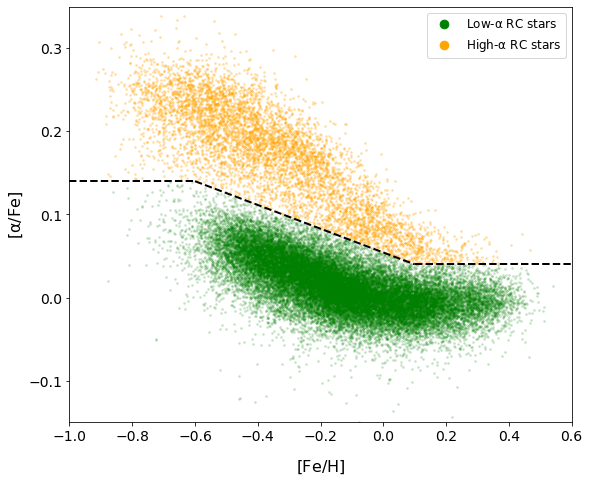

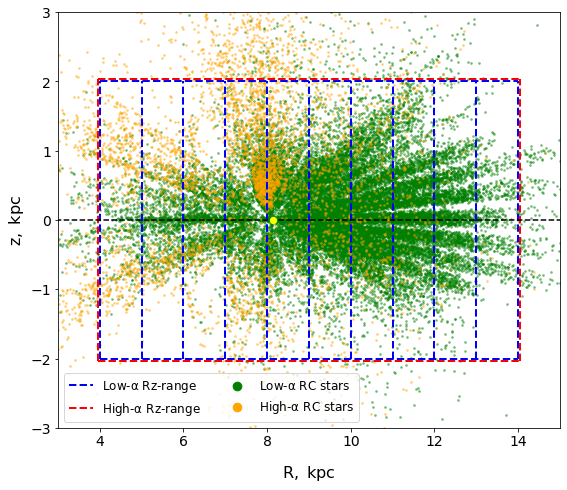

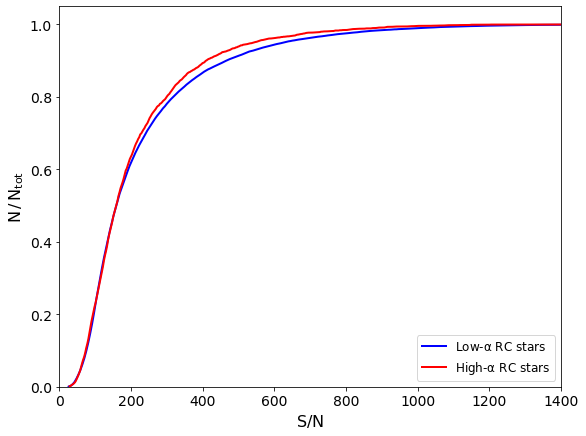

In [3]:
# Define spatial grids
# --------------------------------
zlow_d, zup_d = 0, 2000  # lower and upper z where RC stars are selected (thin disk), pc
zlow_t, zup_t = 0, 2000  # -//- (thick disk)
Rmin_t, Rmax_t = 4, 14   # range of Galactocentric distances for the thick disk, kpc


# Apply cuts on R and z to the data
# -------------------------------------------
AL_rzcut = RC_DATA_AL[np.logical_and.reduce([np.abs(RC_DATA_AL['z']) >= zlow_d,np.abs(RC_DATA_AL['z']) <= zup_d,
                                             RC_DATA_AL['rg'] >= p.Rmin-p.dR/2,RC_DATA_AL['rg'] < p.Rmax+p.dR/2])]
AH_rzcut = RC_DATA_AH[np.logical_and.reduce([np.abs(RC_DATA_AH['z']) >= zlow_t,np.abs(RC_DATA_AH['z']) <= zup_t,
                                             RC_DATA_AH['rg'] >= Rmin_t,RC_DATA_AH['rg'] <= Rmax_t])]
AL_rzcut.write('apogee-rc-DR16-alpha-low_rzcut.fits',overwrite=True)
AH_rzcut.write('apogee-rc-DR16-alpha-high_rzcut.fits',overwrite=True)

print(len(AL_rzcut['SNR']),'and',len(AH_rzcut['SNR']),' - stars in the samples')

# Check signal-to-noise of the samples
hist_snrd, bins_snrd = np.histogram(AL_rzcut['SNR'],bins=500,
        weights=np.linspace(1/len(AL_rzcut['SNR']),1/len(AL_rzcut['SNR']),len(AL_rzcut['SNR'])))
hist_snrt, bins_snrt = np.histogram(AH_rzcut['SNR'],bins=500,
        weights=np.linspace(1/len(AH_rzcut['SNR']),1/len(AH_rzcut['SNR']),len(AH_rzcut['SNR'])))
hist_snrd = np.cumsum(hist_snrd)
hist_snrt = np.cumsum(hist_snrt)

fr = 0.95
fr1 = 1 - fr
ind_frd = np.where(np.abs(hist_snrd-fr1)==np.amin(np.abs(hist_snrd-fr1)))[0][0]
ind_frt = np.where(np.abs(hist_snrt-fr1)==np.amin(np.abs(hist_snrt-fr1)))[0][0]

print(fr*100,'% of stars in the samples (low- and high-alpha) have S/N larger than',
      int(round(bins_snrd[ind_frd],0)),'and',int(round(bins_snrt[ind_frt],0)),', respectively')


# Plots
# -------------------------------------------

# [Alpha/Fe]-[Fe/H] plane
f, ax = plt.subplots(figsize=(9,7))
#sc1 = ax.scatter(RC_DATA['FE_H'],RC_DATA['ALPHAFE'],
#                 color='grey',label='$\mathrm{APOGEE RC DR16}$',s=3)
sc2 = ax.scatter(RC_DATA_AL['FE_H'],RC_DATA_AL['ALPHAFE'],
                 color='green',label='$\mathrm{Low}$'+'-'+r'$\mathrm{\alpha \ RC \ stars}$',s=3)
sc3 = ax.scatter(RC_DATA_AH['FE_H'],RC_DATA_AH['ALPHAFE'],
                 color='orange',label='$\mathrm{High}$'+'-'+r'$\mathrm{\alpha \ RC \ stars}$',s=3)
ax.plot([-1,feh_br1],[afe_br1,afe_br1],ls='--',c='k',lw=2)
ax.plot([feh_br2,0.6],[afe_br2,afe_br2],ls='--',c='k',lw=2)
ax.plot([feh_br1,feh_br2],[afe_br1,afe_br2],ls='--',c='k',lw=2)
ax.set_xlabel('$\mathrm{[Fe/H]}$',fontsize=fnt1,labelpad=15)
ax.set_ylabel(r'$\mathrm{[\alpha/Fe]}$',fontsize=fnt1)
ax.set_xlim(-1,0.6)
ax.set_ylim(-0.15,0.35)
plt.legend(loc=1,prop={'size':fnt2},markerscale=5)
#sc1.set_alpha(0.2)
sc2.set_alpha(0.15)
sc3.set_alpha(0.25)
f.subplots_adjust(top=0.95)
f.savefig(os.path.join(a.T['metplt'],'Fe-Alpha-plane_apogee_rc_dr16.pdf'),rasterized=True)


# Rz-plane
f, ax = plt.subplots(figsize=(9,7))
sc1 = ax.scatter(RC_DATA_AL['rg'],RC_DATA_AL['z']/1e3,
                 color='green',label='$\mathrm{Low}$'+'-'+r'$\mathrm{\alpha \ RC \ stars}$',s=3,zorder=1)
sc2 = ax.scatter(RC_DATA_AH['rg'],RC_DATA_AH['z']/1e3,
                 color='orange',label='$\mathrm{High}$'+'-'+r'$\mathrm{\alpha \ RC \ stars}$',s=3,zorder=2)
ax.plot([2,16],[0,0],ls='--',c='k',zorder=3)
ax.scatter(8.15,0.0028,color='yellow',s=40,zorder=4)
ax.plot([p.Rmin-p.dR/2,p.Rmax+p.dR/2],[-zup_d/1e3,-zup_d/1e3],c='b',lw=2,ls='--',
        label='$\mathrm{Low}$'+'-'+r'$\mathrm{\alpha \ Rz}$'+'-'+'$\mathrm{range}$')
ax.plot([p.Rmin-p.dR/2,p.Rmax+p.dR/2],[zup_d/1e3,zup_d/1e3],c='b',lw=2,ls='--')
ax.plot([p.Rmax+p.dR/2,p.Rmax+p.dR/2],[-zup_d/1e3,zup_d/1e3],c='b',lw=2,ls='--')
for i in range(a.Rbins):
    ax.plot([a.R[i]-p.dR/2,a.R[i]-p.dR/2],[-zup_d/1e3,zup_d/1e3],c='b',lw=2,ls='--')
ax.plot([Rmin_t-0.05,Rmax_t+0.05],[-zup_t/1e3-0.03,-zup_t/1e3-0.03],c='r',lw=2,ls='--',
        label='$\mathrm{High}$'+'-'+r'$\mathrm{\alpha \ Rz}$'+'-'+'$\mathrm{range}$')
ax.plot([Rmin_t-0.05,Rmax_t+0.05],[zup_t/1e3+0.03,zup_t/1e3+0.03],c='r',lw=2,ls='--')
ax.plot([Rmin_t-0.05,Rmin_t-0.05],[-zup_t/1e3-0.03,zup_t/1e3+0.03],c='r',lw=2,ls='--')
ax.plot([Rmax_t+0.05,Rmax_t+0.05],[-zup_t/1e3-0.03,zup_t/1e3+0.03],c='r',lw=2,ls='--')
ax.set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1,labelpad=15)
ax.set_ylabel(r'$\mathrm{z, \ kpc}$',fontsize=fnt1)
ax.set_xlim(3,15)
ax.set_ylim(-3,3)
plt.legend(loc=3,ncol=2,prop={'size':fnt2},markerscale=5)
sc1.set_alpha(0.4)
sc2.set_alpha(0.4)
f.subplots_adjust(top=0.95)
f.savefig(os.path.join(a.T['metplt'],'Rz-plane_apogee_rc_dr16.pdf'),rasterized=True)


# SNR plot
f,ax = plt.subplots(figsize=(9,7))
ax.plot(bins_snrd[:-1],hist_snrd,lw=2,color='b',label='$\mathrm{Low}$'+'-'+r'$\mathrm{\alpha \ RC \ stars}$')
ax.plot(bins_snrt[:-1],hist_snrt,lw=2,color='r',
        label='$\mathrm{High}$'+'-'+r'$\mathrm{\alpha \ RC \ stars}$')       
ax.set_xlim(0,1400)
ax.set_ylim(0,1.05)
ax.set_xlabel('$\mathrm{S/N}$',fontsize=fnt1)
ax.set_ylabel('$\mathrm{N \, / \, N_{tot}}$',fontsize=fnt1)
plt.legend(loc=4,prop={'size':fnt2})
plt.show()
f.savefig(os.path.join(a.T['metplt'],'SNR_apogee_rc_dr16.png'),rasterized=True)



   R [kpc]        N      sigma_FeH [dex]
 ----------------------------------------- 
  Low-alpha  
 -----------------------------------------
    4.0-5.0      399         0.06       
    5.0-6.0      927         0.05       
    6.0-7.0      1420        0.03       
    7.0-8.0      4345        0.08       
    8.0-9.0      5769        0.11       
    9.0-10.0     6574        0.13       
   10.0-11.0     6016        0.12       
   11.0-12.0     4464        0.12       
   12.0-13.0     2378        0.11       
   13.0-14.0     631         0.11       
                Total       Mean     
                 32923       0.11        
 ----------------------------------------- 
 High-alpha  
 ----------------------------------------- 
    4.0-14.0     4432        0.17       


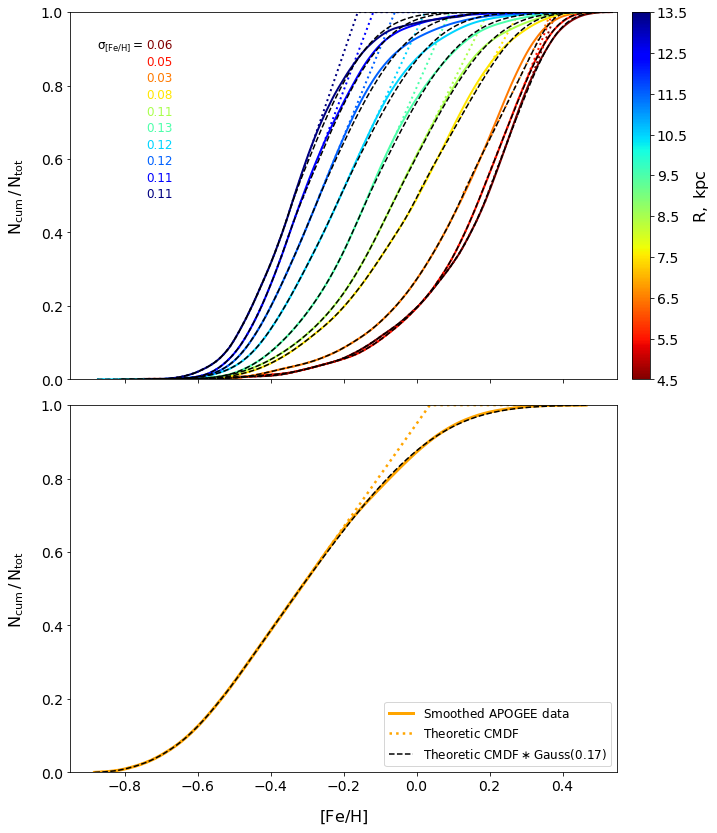

In [4]:
# Define metallicity grid
# -----------------------------------
dFeH = 0.05
FeH_bins_hist = np.arange(-1,0.6 + dFeH,dFeH)
FeH_bins_histc = np.add(FeH_bins_hist,dFeH/2)[:-1]


# Get metallicity distributions from the data
# ---------------------------------------------
#   Low-alpha
FeH_dist_data_al  = np.zeros((a.Rbins,int(len(FeH_bins_histc))))
for i in range(a.Rbins):
    rc_R = AL_rzcut[np.logical_and.reduce([AL_rzcut['rg'] >= a.R[i] - p.dR/2,AL_rzcut['rg'] < a.R[i] + p.dR/2])]
    FeH_dist_data_al[i] = np.histogram(rc_R['FE_H'],bins=FeH_bins_hist)[0]
    
#   High-alpha                         
FeH_dist_data_ah = np.histogram(AH_rzcut['FE_H'],bins=FeH_bins_hist)[0]

np.savetxt(os.path.join(a.T['mettab'],'FeH_N_d.txt'),
               np.hstack((FeH_bins_hist[:-1].reshape(len(FeH_bins_hist[:-1]),1),
                          FeH_bins_hist[1:].reshape(len(FeH_bins_hist[1:]),1),FeH_dist_data_al.T)),
               header='[Fe/H]_min, [Fe/H]_max, N_data (thin disk) for R = ['+str(p.Rmin)+','+str(p.Rmax)+\
                      '] kpc with dR = '+str(p.dR)+' kpc')
np.savetxt(os.path.join(a.T['mettab'],'FeH_N_t.txt'),
           np.stack((FeH_bins_hist[:-1],FeH_bins_hist[1:],FeH_dist_data_ah),axis=-1),
           header='[Fe/H]_min, [Fe/H]_max, N_data (thick disk) for R = ['+str(Rmin_t)+','+str(Rmax_t)+'] kpc')


# Recalculate to cumulative and deconvolve at the metal-rich end
# ----------------------------------------------------------------

FeH_bins_d, Ncum_sm_d = np.zeros((a.Rbins,a.jd)),np.zeros((a.Rbins,a.jd))
Ncum_deconv_d, Ncum_conv_d, FeH_sigma_d = np.zeros((a.Rbins,a.jd)),np.zeros((a.Rbins,a.jd)), np.zeros((a.Rbins))

rc_al = np.stack((AL_rzcut['rg'],AL_rzcut['RC_DIST'],AL_rzcut['z']/1e3,AL_rzcut['FE_H']),axis=-1)
rc_ah = np.stack((AH_rzcut['rg'],AH_rzcut['RC_DIST'],AH_rzcut['z']/1e3,AH_rzcut['FE_H']),axis=-1)

print('\n','{:^11}'.format('R [kpc]'),'{:^11}'.format('N'),
      '{:^11}'.format('sigma_FeH [dex]\n'),'-'*41,'\n','{:^11}'.format('Low-alpha'),'\n','-'*41)

for i in range(a.Rbins):
    mc = amr.get_metcum((a.R[i]-p.dR/2,a.R[i]+p.dR/2),(zlow_d,zup_d),rc_al,a)
    FeH_bins_d[i], Ncum_sm_d[i] = mc[0], mc[1]
    if a.R[i]+p.dR/2 < 7:
        y1, y2 = 0.4, 0.8
    else:
        y1, y2 = 0.3, 0.7
    Ncum_deconv_d[i], Ncum_conv_d[i], FeH_sigma_d[i] = amr.get_deconvolved(FeH_bins_d[i],Ncum_sm_d[i],(y1,y2)) 
    print('{:^16}'.format(str(a.R[i]-p.dR/2)+'-'+str(a.R[i]+p.dR/2)),
          '{:<11}'.format(np.int(np.sum(FeH_dist_data_al[i]))),
          '{:<11}'.format(np.round(FeH_sigma_d[i],2)))
    np.savetxt(os.path.join(a.T['mettab'],''.join(('CMDF_R',str(a.R[i]),'.txt'))),
                            np.stack((FeH_bins_d[i], Ncum_sm_d[i]),axis=-1),header='[FE/H], N_cum/N_tot')
    
#   High-alpha
mc = amr.get_metcum([Rmin_t,Rmax_t],[zlow_t,zup_t],rc_ah,a)
FeH_bins_t, Ncum_sm_t = mc[0], mc[1]
Ncum_deconv_t, Ncum_conv_t, FeH_sigma_t = amr.get_deconvolved(FeH_bins_t,Ncum_sm_t,(0.4,0.6))


# Save all histograms 
# Thin disk
for i in range(a.Rbins):
    np.savetxt(os.path.join(a.T['mettab'],''.join(('FeH_Ncum_data_d_R',str(a.R[i]),'.txt'))),
               np.stack((FeH_bins_d[i],Ncum_sm_d[i]),axis=-1),
               header='[Fe/H], Ncum_data_smoothed/N_tot (thin disk)')
    np.savetxt(os.path.join(a.T['mettab'],''.join(('FeH_Ncum_deconv_d_R',str(a.R[i]),'.txt'))),
               np.stack((FeH_bins_d[i],Ncum_deconv_d[i]),axis=-1),
               header='[Fe/H], Ncum_deconvolved/N_tot (thin disk)')
    np.savetxt(os.path.join(a.T['mettab'],''.join(('FeH_Ncum_conv_d_R',str(a.R[i]),'.txt'))),
               np.stack((FeH_bins_d[i],Ncum_conv_d[i]),axis=-1),
               header='[Fe/H], Ncum_convolved/N_tot (thin disk)')                  
np.savetxt(os.path.join(a.T['mettab'],'FeH_sigma_d.txt'),np.stack((a.R-p.dR/2,a.R+p.dR/2,FeH_sigma_d),axis=-1),
           header='Rmin[kpc], Rmax[kpc], sigma_FeH (thin disk)')
# Thick disk
np.savetxt(os.path.join(a.T['mettab'],'FeH_Ncum_t.txt'),np.stack((FeH_bins_t,Ncum_sm_t,Ncum_deconv_t,Ncum_conv_t),
          axis=-1),header='[Fe/H], Ncum_data_smoothed/N_tot, Ncum_deconvolved/N_tot,\
                   Ncum_convolved/N_tot (thick disk) for R = ['+str(Rmin_t)+','+str(Rmax_t)+'] kpc')
np.savetxt(os.path.join(a.T['mettab'],'FeH_sigma_t.txt'),np.stack(([Rmin_t],[Rmax_t],[FeH_sigma_t]),axis=-1),
           header='Rmin[kpc], Rmax[kpc], sigma_FeH (thick disk)')


print('{:^12}'.format(''),'{:^11}'.format('Total'),'{:^11}'.format('Mean'),'\n',
      '{:^15}'.format(''),'{:<11}'.format(np.int(np.sum(np.sum(FeH_dist_data_al)))),
      '{:<11}'.format(np.round(np.mean(FeH_sigma_d[i]),2)),'\n','-'*41,'\n',
      '{:^11}'.format('High-alpha'),'\n','-'*41,'\n',
      '{:^15}'.format(str(float(Rmin_t))+'-'+str(float(Rmax_t))),
      '{:<11}'.format(np.int(np.sum(FeH_dist_data_ah))),'{:<11}'.format(np.round(FeH_sigma_t,2)))
           
    

# Plot CMDFs
# -------------------------------------------

rbins_cmap = mpl.cm.get_cmap('jet_r')
rbins_cols = rbins_cmap(np.linspace(0,1,a.Rbins))

fig, ax = plt.subplots(ncols=1,nrows=2,figsize=(10,12))
# Low-alpha 
ax[0].set_xlim((-0.95,0.55))
ax[0].set_ylim((0,1))
ax[0].set_xticklabels([])
#ax[0].set_xlabel('$\mathrm{[Fe/H]}$',fontsize=fnt1,labelpad=15)
ax[0].set_ylabel('$\mathrm{N_{cum} \, / \, N_{tot}}$',fontsize=fnt1,labelpad=15)
line_segments1 = LineCollection([list(zip(FeH_bins_d[i],Ncum_deconv_d[i])) for i in np.arange(a.Rbins)],
                                linewidths=2.0,cmap = mpl.cm.jet_r,ls=':',
                                norm = mpl.colors.Normalize(vmin=p.Rmin,vmax=p.Rmax))
line_segments2 = LineCollection([list(zip(FeH_bins_d[i], Ncum_sm_d[i])) for i in np.arange(a.Rbins)],
                                linewidths=2.0,cmap = mpl.cm.jet_r,
                                norm = mpl.colors.Normalize(vmin=p.Rmin,vmax=p.Rmax))
line_segments1.set_array(a.R)
line_segments2.set_array(a.R)
im = ax[0].add_collection(line_segments1)
ax[0].add_collection(line_segments2)
ax[0].text(0.05,0.9,'$\mathrm{\sigma_{[Fe/H]}=}$',fontsize=fnt2,transform=ax[0].transAxes)                   
for i in range(a.Rbins):
    ax[0].plot(FeH_bins_d[i],savgol_filter(Ncum_conv_d[i],51,3),lw=1.5,ls='--',color='k')
    ax[0].text(0.14,0.9-i*0.045,str(np.round(FeH_sigma_d[i],2)),fontsize=fnt2,color=rbins_cols[i],
            transform=ax[0].transAxes) 
fig.subplots_adjust(left=0.1,top=0.95,bottom=0.07,right=0.86,hspace=0.07)
pos = ax[0].get_position()
cax = fig.add_axes([pos.x0+pos.width+0.02,pos.y0,0.025,pos.height])
cbar = fig.colorbar(im,cax=cax,orientation='vertical')
cbar.set_ticks(a.R)
cbar.set_label('$\mathrm{R, \ kpc}$',fontsize=fnt1)
# High-alpha 
ax[1].plot(FeH_bins_t,Ncum_sm_t,lw=3,c='orange',label='$\mathrm{Smoothed \ APOGEE \ data}$')
ax[1].plot(FeH_bins_t,Ncum_deconv_t,lw=2.5,c='orange',ls=':',label='$\mathrm{Theoretic \ CMDF}$')
ax[1].plot(FeH_bins_t,Ncum_conv_t,lw=1.5,c='k',ls='--',
        label=r'$\mathrm{Theoretic \ CMDF \ast Gauss(}$'+str(round(FeH_sigma_t,2))+'$\mathrm{)}$')
ax[1].set_xlabel('$\mathrm{[Fe/H]}$',fontsize=fnt1,labelpad=15)
ax[1].set_ylabel(r'$\mathrm{N_{cum}\, / \, N_{tot}}$',fontsize=fnt1,labelpad=15)
ax[1].set_xlim(-0.95,0.55)
ax[1].set_ylim(0,1)
ax[1].legend(loc=4,prop={'size':fnt2})
plt.show()
fig.savefig(os.path.join(a.T['metplt'],'CMDF_rc_alow-ahigh.pdf'))


## Step 2. CADFs of the RC sample from the JJ model 

### Population synthesis
During the first run, the input AMR and mass loss function g of the thin and thick disk are 
those which are prescribed by the model parameters from the parameter file 
(there are no explicit parameters for g function, but it depends on AMR). 
In the end of this notebook, we arrive at the new AMR, and then the calculation of the model predictions 
(CADF and RC metallicity distributions in R-bins) can be repeated, but with the updated AMR and g.
This has to be repeated (starting from here - by end of the notebook) until the obtained AMR converges 
to a stable shape (~3-5 iterations). 

Don't forget to change the iteration number n_iter each time to save the produced plots separately for each cycle. 


In [5]:
# Update AMR and g if needed
#-------------------------------------

# Iteration number
n_iter = 1

if n_iter > 1:
    inp['AMRd'] = AMRd_from_data[1]  # index 0 = model without z-correction (see below)
                                     #       1 = model with z-correction (recommended)
                                     #       2 = model with z-correction and warp 
    inp['AMRt'] = AMRt_from_data  

    amr = AMR()
    inp['gt'] = amr.mass_loss(a.t,inp['AMRt'])[:a.jt]
    inp['gd'] = np.array([amr.mass_loss(a.t,i) for i in inp['AMRd']])


# Run the model
#-------------------------------------

timer = Timer()
t_start = timer.start()

# Calculate potential-density pairs 
if __name__ == '__main__':
    disk_builder(p,a,inp)

# Define IMF 
imf = IMF(0.08,100)
mass, Nmdm = imf.BPL_4slopes(p.a0,p.a1,p.a2,p.a3,p.m0,p.m1,p.m2)

# Create populations 
#   For the Solar neighbourhood
if __name__ == '__main__':
    stellar_assemblies_r(p.Rsun,p,a,inp['AMRd0'],inp['AMRt'],inp['SFRd0'],inp['SFRt0'],
                         p.sigmash,imf.number_stars,'Padova',3)
#   For other distances
for i in range(a.Rbins):
    indr = int(a.R[i]//p.dR - p.Rmin//p.dR)
    if __name__ == '__main__':
        stellar_assemblies_r(a.R[i],p,a,inp['AMRd'][indr],inp['AMRt'],inp['SFRd'][indr],inp['SFRt'][indr],
                             inp['SigmaR'][-1][indr],imf.number_stars,'Padova',3)

# Select RC stars 
# Reminder: 'd' = thin disk, 't' = thick disk, 'sh' = stellar halo, 'rc' or 'rc+' = RC stars
                       
mw_comp = ['d','t']
kw_rc = {'save':True,'fig':True,'close':True}
R_array = [p.Rsun]
R_array.extend(a.R)

print('{:<11}'.format('\nR [kpc]'),'{:<11}'.format('RC stars'))

for i in range(a.Rbins+1): 
    print('{:<1}'.format(''),'{:<11}'.format(R_array[i]),'{:<1}'.format(''),end='')
    pop = GetPopulations('Padova',R_array[i],p,a)
    for k in range(len(mw_comp)):
        pop.rc_clean(mw_comp[k],**kw_rc)
    print('{:<11}'.format('x'))
      
print('\n',timer.stop(t_start))


Results of this run will be saved to already existing folder output/4.5R13.5_dR1.0_tutorial4_model+zw_newfit_dm

Output directory tree created.

---Local run---

        Process 8.17  : exit, time: 0h 0m 0.54s


Input data saved.

Output data saved.

---Local run ended sucessfully---


---Global run---

        Process 5.5   : exit, time: 0h 0m 1.88s
        Process 6.5   : exit, time: 0h 0m 1.84s
        Process 7.5   : exit, time: 0h 0m 1.85s
        Process 4.5   : exit, time: 0h 0m 2.53s
        Process 8.5   : exit, time: 0h 0m 1.28s
        Process 10.5  : exit, time: 0h 0m 1.43s
        Process 9.5   : exit, time: 0h 0m 1.77s
        Process 11.5  : exit, time: 0h 0m 1.66s
        Process 12.5  : exit, time: 0h 0m 1.28s
        Process 13.5  : exit, time: 0h 0m 1.2s


Input data saved.

Output data saved.

---Global run ended sucessfully---

 0h 0m 6.14s

Stellar population synthesis for R = 8.17 kpc:
Warning. Some of modeled metallicities (halo -- and this is valid for all R) a

### Selection effects

The Rz-plot of our samples shows that the RC stars are distributed in space very unevenly.
From our model we know that the thin-disk RC stars have very different age distributions at different z, 
so in order to model the realistic age distributions of the low-alpha sample, 
it is important to properly account for the relative weghts of the different z-bins. 

We use a simple approach. At each R we do the following: 
  - calculate Nz_data - a distribution of the RC stars over |z| (normalized to a midplane bin); 
  - calculate Nz_model - an expected vertical number density from the model (same normalization);
  - calculate a ratio of them, z_weights = Nz_data/Nz_model.
  
Quantity z_weights shows how much the observed vertical distribution of stars deviates 
from the expected vertical density law of a complete RC population. Assuming that our model is correct, 
this deviation reflects the sample incompleteness and geometry. Thus, we can use z_weights to modify 
our modeled RC age distributions to mimic the geometry and incompleteness of the real APOGEE sample. 
We also test impact of the warp on our modeling.  
 
The thick disk (high-alpha population) is a very homogenous component - it has the same age distribution 
at all z in the model, and we see no variation of the metallicity distribution of the high-alpha population 
with R and z. Thus, even if the predicted thick disk vertical number density law does not exactly follow 
the real vertical distribution of the sample, this does not have any impact on the modeled age distributions, 
and therefore, no correction is needed.



       R [kpc]      z_warp [pc]  
       4.0-5.0         0            
       5.0-6.0         0            
       6.0-7.0         0            
       7.0-8.0         0            
       8.0-9.0         0            
       9.0-10.0        19           
      10.0-11.0        64           
      11.0-12.0        108          
      12.0-13.0        152          
      13.0-14.0        197          


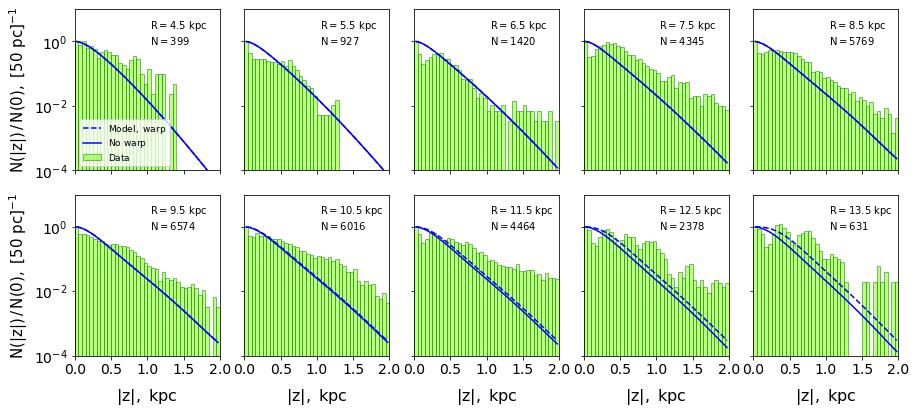

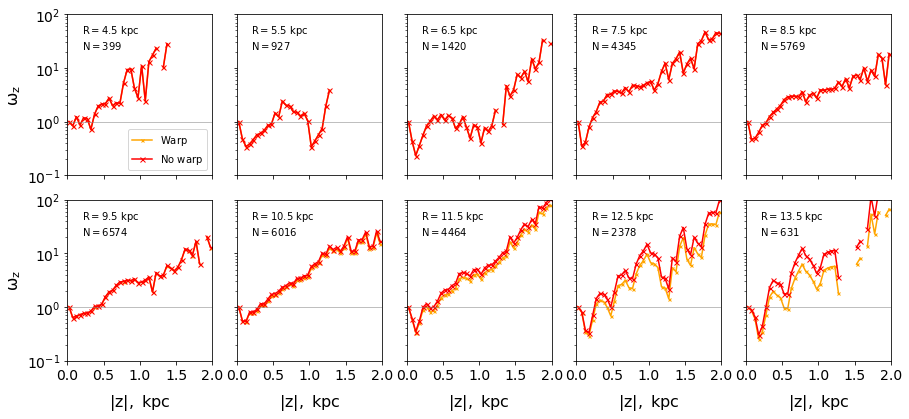

In [14]:
# Define several functions
# ---------------------------

def z_warp(R,mode):
    # Calculates vertical displacement of the disk (in kpc) from the Galactic mid-plane z=0 pc 
    # at a given Galactocentric radius R. The warp models are taken from 
    # Poggio et al. (2020), https://arxiv.org/pdf/1912.10471.pdf (Fig. 3, p18) and 
    # Cheng et al. (2020), https://arxiv.org/pdf/2010.10398.pdf 
    # Displacement is calculated at the line connecting the Sun and Galactic center. 
    
    if mode=='chen-lin':
        h0w, Rw, alpha, phiw = 0.148, 9.06, 1, 17.4              # Chen, linear model
    if mode=='chen-pow':
        h0w, Rw, alpha, phiw = 0.06, 7.55, 1.33, 17.5            # Chen, power-law
    if mode=='yusifov':
        h0w, Rw, alpha, phiw = 0.037, 6.21, 1.4, 14.5            # Yusifov
    if mode=='cheng':
        R1, R2, Rw, alpha, phiw = 8.87, 17.78, 1.2, 1.53, 17.5   # Cheng
    hR = 0
    if mode=='cheng':
        if R > R1:
            hR = Rw/(R2-R1)*(R-R1)**alpha            
    else:
        if R > Rw:
            hR = h0w*(R-Rw)**alpha 
    zw = hR*np.sin(np.deg2rad(phiw)) 
    return zw


def nz_sech(z,n0,alpha,h):
    # Vertical density profile of a single isothermal population, 
    # sech-law, Msun/pc^3
    
    rho = n0/np.cosh(z/alpha/h)**alpha
    return rho


# Derive z_weights
# ---------------------------

# Define z-grid
Delta_z = 50                   # pc, step in z
nzd = int(zup_d/Delta_z)       # number of z-bins to the weights 
z_coef = Delta_z//p.dz         # number of the intrinsic JJ-model z-bins within a single z_weight-bin
indz_slice = int(zup_d//p.dz)  # index of the last z-bin (fine grid)

# Calculate z_weighs for the thin disk
warp_model = 'chen-lin'

Nz_data, Nz_model, z_weights = np.zeros((a.Rbins,nzd)), np.zeros((a.Rbins,nzd)), np.zeros((a.Rbins,nzd))
Nz_model_warp, z_weights_warp = np.zeros((a.Rbins,nzd)), np.zeros((a.Rbins,nzd))

'''
# Comparison of the four warp models (Cheng model predicts the strongest warp)
for i in range(a.Rbins):
    z_w = np.array([z_warp(a.R[i],'chen-lin'),z_warp(a.R[i],'chen-pow'),
                    z_warp(a.R[i],'yusifov'),z_warp(a.R[i],'cheng')])
    z_w = np.array(np.round(z_w*1e3,0),dtype=np.int)
    print(a.R[i],'\t',z_w[0],'\t',z_w[1],'\t',z_w[2],'\t',z_w[3])
'''

print('\n','{:<2}'.format(''),'{:^14}'.format('R [kpc]'),'{:^14}'.format('z_warp [pc]'))

for i in range(a.Rbins):
    
    # Vertical distribution of the RC stars from the data
    rc_R = AL_rzcut[np.logical_and.reduce([AL_rzcut['rg'] >= a.R[i] - p.dR/2,AL_rzcut['rg'] < a.R[i] + p.dR/2])]
    Nz_data[i], zbins = np.histogram(np.abs(rc_R['z']),bins=nzd,range=(zlow_d,zup_d))

    # Vertical distribution of the RC stars in the model
    #    (1) No warp
    Nz_r = rhoz_monoage('d',a.R[i],[0,tp],p,a,mode_pop='rc',number=True,between=True)[0]
    Nz_model[i] = [np.sum(Nz_r[int(k*z_coef):int((k+1)*z_coef)]) for k in np.arange(nzd)] 
    
    #    (2) With warp
    z_w = z_warp(a.R[i],warp_model)      # vertical shift of the disk at a given R
    
    if z_w > 0:
        indz_warp = int(z_w*1e3//p.dz)
        Nz_model_half = Nz_r/2
        # Sometimes the vertical density law needs to be extrapolated to z > p.zmax 
        # in order to calculate the N(|z|) profile of the warped disk. 
        # For extrapolation, we fit the second half of the modeled vertical density law 
        # with the sech-law profile. 
        if indz_slice + indz_warp > a.n:
            popt,pcov = curve_fit(nz_sech,a.z[int(indz_slice/2):],
                                  Nz_model_half[int(indz_slice/2):],p0=[5e-5,1.0,500])
            Nz_model_extrapolated = [nz_sech(p.zmax+i*p.dz,*popt) for i in range(indz_slice + indz_warp - a.n)]
            '''
            # Uncomment to check the sech-law fit of the predicted vertical density profile
            # (plot for a single R-bin)
            if i==int(a.Rbins-1):
                z_long = np.concatenate((a.z,[p.zmax+i*p.dz for i in range(indz_slice + indz_warp - a.n)]))
                plt.figure()
                plt.semilogy(a.z,Nz_model_half)
                plt.semilogy(z_long,[nz_sech(i,*popt) for i in z_long],ls='--')
                plt.show()
            '''
            Nz_model_half = np.concatenate((Nz_model_half,Nz_model_extrapolated),axis=0)
        Nz_mw = np.zeros((2*indz_slice))
        Nz_mw[:int(indz_slice + indz_warp)] = Nz_model_half[:int(indz_slice + indz_warp)][::-1]
        Nz_mw[int(indz_slice + indz_warp):] = Nz_model_half[:int(indz_slice - indz_warp)]
        Nz_mw = np.add(Nz_mw[:indz_slice][::-1],Nz_mw[indz_slice:])
        Nz_model_warp[i] = [np.sum(Nz_mw[int(k*z_coef):int((k+1)*z_coef)]) for k in np.arange(nzd)]
    else:
        Nz_model_warp[i] = Nz_model[i]
    print('{:<2}'.format(''),'{:^16}'.format(str(a.R[i]-p.dR/2)+'-'+str(a.R[i]+p.dR/2)),'{:<2}'.format(''),
          '{:<13}'.format(int(round(1e3*z_w,0))))
    
    # Find z_weights
    z_weights[i] = (Nz_data[i]/Nz_data[i][0])/(Nz_model[i]/Nz_model[i][0])
    z_weights_warp[i] = (Nz_data[i]/Nz_data[i][0])/(Nz_model_warp[i]/Nz_model_warp[i][0])
    

np.savetxt(os.path.join(a.T['mettab'],''.join(('z_weights_apogee_rc_dr16_low-alpha.txt'))),
           np.hstack((zbins[:-1].reshape(nzd,1),zbins[1:].reshape(nzd,1),z_weights.T)),
           header='zmin[pc], zmax[pc], weight for R=[' + str(p.Rmin) + ',' + str(p.Rmax) +\
           '] kpc with dR = '+str(p.dR) + ' kpc')
np.savetxt(os.path.join(a.T['mettab'],''.join(('z_weights_apogee_rc_dr16_low-alpha_warp.txt'))),
           np.hstack((zbins[:-1].reshape(nzd,1),zbins[1:].reshape(nzd,1),z_weights_warp.T)),
           header='zmin[pc], zmax[pc], weight for R=[' + str(p.Rmin) + ',' + str(p.Rmax) +\
           '] kpc with dR = '+str(p.dR) + ' kpc, warp model = ' + warp_model)


# Plots
# ---------------------------
# Nz_data and Nz_model
if p.dR==0.5:
    fig, ax = plt.subplots(nrows=3,ncols=7,figsize=(15,8.5))
if p.dR==1.0:
    f, ax = plt.subplots(nrows=2,ncols=5,figsize=(13,5.8))
#f.suptitle('$\mathrm{Vertical \ distribution \ of \ APOGEE \ DR16 \ low}$'+'-'+
#           r'$\mathrm{[\alpha/Fe] \ RC \ stars \ in \ R}$'+'-'+'$\mathrm{bins, \ \Delta R = }$' + 
#           str(p.dR) + '$\mathrm{\ kpc}$',fontsize=fnt1,y=0.95)
for i in range(a.Rbins):
    if p.dR==1.0:
        i1,i2 = int(i//5), int(i%5)
    if p.dR==0.5:
        i1,i2 = int(i//7), int(i%7)
    ax[i1,i2].hist(np.add(zbins,Delta_z/2)[:-1]/1e3,bins=zbins/1e3,range=(zlow_d/1e3,zup_d/1e3),
                   weights=Nz_data[i]/Nz_data[i][0],color='lawngreen',alpha=0.5,edgecolor='g',
                   label='$\mathrm{Data}$') 
    ax[i1,i2].plot(np.add(zbins,Delta_z/2)[:-1]/1e3,Nz_model_warp[i]/Nz_model_warp[i][0],c='b',ls='--',
                  label='$\mathrm{Model, \ warp}$')
    ax[i1,i2].plot(np.add(zbins,Delta_z/2)[:-1]/1e3,Nz_model[i]/Nz_model[i][0],c='b',
                   label='$\mathrm{No \ warp}$')
    ax[i1,i2].set_xlim(zlow_d/1e3,zup_d/1e3)
    ax[i1,i2].set_yscale('log')
    ax[i1,i2].set_ylim(1e-4,10) 
    ax[i1,i2].set_xticks(np.linspace(zlow_d/1e3,zup_d/1e3,5))
    ax[i1,i2].set_xticklabels([float(str(i).rstrip('0').rstrip('.')) 
                               for i in np.linspace(zlow_d/1e3,zup_d/1e3,5)])
    ax[i1,i2].text(0.52,0.88,'$\mathrm{R=}$'+str(a.R[i])+'$\mathrm{ \ kpc}$',
                   fontsize=10,transform=ax[i1,i2].transAxes)
    ax[i1,i2].text(0.52,0.78,'$\mathrm{N=}$'+str(int(np.sum(Nz_data[i]))),fontsize=10,
                   transform=ax[i1,i2].transAxes)
    if p.dR==0.5:
        if i1==2 or (i1==1 and i2==6):
            ax[i1,i2].set_xlabel('$\mathrm{|z|, \ kpc}$',fontsize=fnt1,labelpad=10)
        else:
            ax[i1,i2].set_xticklabels([])
        if i2%7!=0:
            ax[i1,i2].set_yticklabels([])
        else:
            ax[i1,i2].set_ylabel('$\mathrm{N(|z|) \, / \, N(0), \ [}$'+str(Delta_z)+\
                                 '$\mathrm{\ pc ]^{-1}}$',fontsize=fnt1-1)
    if p.dR==1.0:
        if i1==1:
            ax[i1,i2].set_xlabel('$\mathrm{|z|, \ kpc}$',fontsize=fnt1,labelpad=10)
        else:
            ax[i1,i2].set_xticklabels([])
        if i2!=0:
            ax[i1,i2].set_yticklabels([])
        else:
            ax[i1,i2].set_ylabel('$\mathrm{N(|z|) \, / \, N(0), \ [}$'+str(Delta_z)+\
                                 '$\mathrm{\ pc ]^{-1}}$',fontsize=fnt1-1)
ax[0,0].legend(loc=3,prop={'size':9},labelspacing=0.15)       
if p.dR==0.5:
    ax[2,6].set_axis_off()
f.subplots_adjust(left=0.07,hspace=0.15,wspace=0.17,bottom=0.12,top=0.95,right=0.95)
plt.show()
f.savefig(os.path.join(a.T['metplt'],'Nz_dm_apogee_rc_dr16_low-alpha.pdf'))


# z_weights
# For plotting we replace zeros (empty bins) with nans
z_weights_nans = np.copy(z_weights)
z_weights_nans[z_weights_nans==0]=np.nan
z_weights_warp_nans = np.copy(z_weights_warp)
z_weights_warp_nans[z_weights_warp_nans==0]=np.nan

if p.dR==0.5:
    fig, ax = plt.subplots(nrows=3,ncols=7,figsize=(15,8.5))
if p.dR==1.0:
    f, ax = plt.subplots(nrows=2,ncols=5,figsize=(13,5.8))
#f.suptitle('$\mathrm{Ratio \ of \ the \ normalized \ N(|z|)_{data} \ to \ N(|z|)_{model}}$',fontsize=fnt1,y=0.95)
for i in range(a.Rbins):
    if p.dR==1.0:
        i1,i2 = int(i//5), int(i%5)
    if p.dR==0.5:
        i1,i2 = int(i//7), int(i%7)
    ax[i1,i2].plot(np.add(zbins,Delta_z/2)[:-1]/1e3,z_weights_warp_nans[i],marker='x',c='orange',markersize=3,
                  label='$\mathrm{Warp}$')
    ax[i1,i2].plot(np.add(zbins,Delta_z/2)[:-1]/1e3,z_weights_nans[i],marker='x',c='r',markersize=5,
                  label='$\mathrm{No \ warp}$')
    ax[i1,i2].set_xlim(zlow_d/1e3,zup_d/1e3)
    if p.dR==0.5:
        ax[i1,i2].set_ylim(1e-1,3e2)
    if p.dR==1.0:
        ax[i1,i2].set_ylim(1e-1,1e2)
    ax[i1,i2].set_xticks(np.linspace(zlow_d/1e3,zup_d/1e3,5))
    ax[i1,i2].set_xticklabels([float(str(i).rstrip('0').rstrip('.')) 
                               for i in np.linspace(zlow_d/1e3,zup_d/1e3,5)])
    ax[i1,i2].set_yscale('log')
    ax[i1,i2].text(0.1,0.88,'$\mathrm{R=}$'+str(a.R[i])+'$\mathrm{ \ kpc}$',fontsize=10,
                   transform=ax[i1,i2].transAxes)
    ax[i1,i2].text(0.1,0.78,'$\mathrm{N=}$'+str(int(np.sum(Nz_data[i]))),fontsize=10,
                   transform=ax[i1,i2].transAxes)
    ax[i1,i2].plot([zlow_d/1e3,zup_d/1e3],[1,1],lw=0.5,c='grey')
    if p.dR==0.5:
        if i1==2 or (i1==1 and i2==6):
            ax[i1,i2].set_xlabel('$\mathrm{|z|, \ kpc}$',fontsize=fnt1,labelpad=10)
        else:
            ax[i1,i2].set_xticklabels([])
        if i2%7!=0:
            ax[i1,i2].set_yticklabels([])
        else:
            ax[i1,i2].set_ylabel('$\mathrm{N(|z|) \, / \, N(0), \ [}$'+str(Delta_z)+\
                                 '$\mathrm{\ pc ]^{-1}}$',fontsize=fnt1)
    if p.dR==1.0:
        if i1==1:
            ax[i1,i2].set_xlabel('$\mathrm{|z|, \ kpc}$',fontsize=fnt1,labelpad=10)
        else:
            ax[i1,i2].set_xticklabels([])
        if i2!=0:
            ax[i1,i2].set_yticklabels([])
        else:
            ax[i1,i2].set_ylabel(r'$\mathrm{\omega_z}$',fontsize=fnt1)
ax[0,0].legend(loc=4,prop={'size':10})
if p.dR==0.5:
    ax[2,6].set_axis_off()
f.subplots_adjust(left=0.07,hspace=0.15,wspace=0.17,bottom=0.12,top=0.95,right=0.95)
plt.show()

f.savefig(os.path.join(a.T['metplt'],'z_weights_apogee_rc_dr16_low-alpha.pdf'))


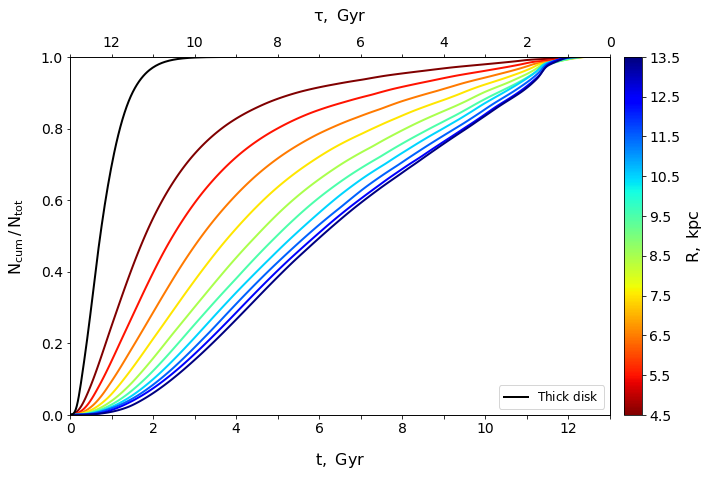

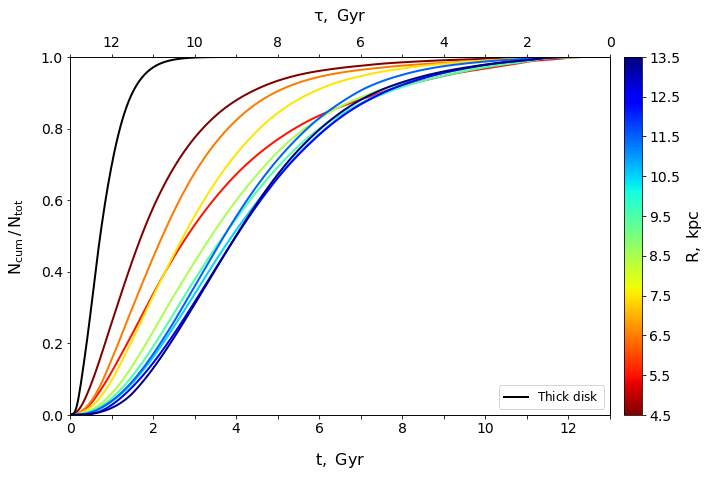

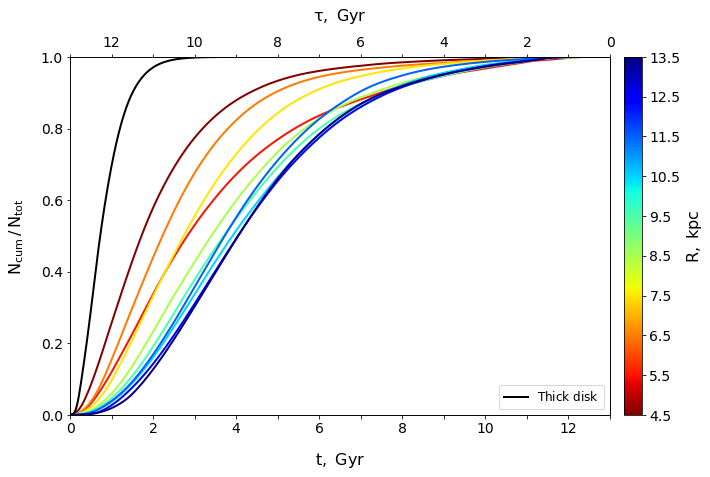

In [7]:
# Calculate age distributions
# (for three cases: model without corrections, with z-correction, with z-correction and warp)
# -------------------------------------------------------------------------------------------

def cumsum_norm(array,mode):
    # Function for converting age ditributions 
    # into cumulative (normalized by the total number of stars)
    if mode=='d':
        array = np.sum(array,axis=0)
        for i in range(a.Rbins):
            array[i] = np.cumsum(array[i])
            array[i] = array[i]/array[i][-1]
    if mode=='t':
        array = np.cumsum(array)
        array = array/array[-1]
    return array


# Thin disk
Age_dist_d = [] 
z_weight = [z_weights,z_weights_warp]

for i in range(3):
    Age_dist_d.append(np.zeros((nzd,a.Rbins,a.jd)))
    for k in range(nzd):
        Age_dist_d[i][k] = agehist('d',[zbins[k],zbins[k+1]],p,a,mode_pop='rc',sigma_gauss=0.05)[0] 
        if i > 0:
            for l in range(a.Rbins):
                Age_dist_d[i][k][l] = Age_dist_d[i][k][l]*z_weight[i-1][l][k]
    Age_dist_d[i] = cumsum_norm(Age_dist_d[i],'d')
    
# Thick disk
Age_dist_t = np.mean(agehist('t',[zlow_t,zup_t],p,a,mode_pop='rc',sigma_gauss=0.05)[0],axis=0)
Age_dist_t = cumsum_norm(Age_dist_t,'t')

# Save tables
np.savetxt(os.path.join(a.T['agetab'],'agedist_d_model.txt'),np.hstack((a.t.reshape(a.jd,1),Age_dist_d[0].T)),
           header='t[Gyr], N_cum/N_tot for R = ['+str(p.Rmin)+','+str(p.Rmax)+'] kpc, dR = '+str(p.dR)+' kpc')
np.savetxt(os.path.join(a.T['agetab'],'agedist_d_model_zw.txt'),np.hstack((a.t.reshape(a.jd,1),Age_dist_d[1].T)),
           header='t[Gyr], N_cum/N_tot for R = ['+str(p.Rmin)+','+str(p.Rmax)+'] kpc, dR = '+str(p.dR)+' kpc')
np.savetxt(os.path.join(a.T['agetab'],'agedist_d_model_zw_warp.txt'),
           np.hstack((a.t.reshape(a.jd,1),Age_dist_d[2].T)),
           header='t[Gyr], N_cum/N_tot for R = ['+str(p.Rmin)+','+str(p.Rmax)+'] kpc, dR = '+str(p.dR)+' kpc')
np.savetxt(os.path.join(a.T['agetab'],'agedist_t.txt'),np.stack((a.t[:a.jt],Age_dist_t[:a.jt]),axis=-1),
           header='t[Gyr], N_cum/N_tot for R = ['+str(Rmin_t)+','+str(Rmax_t)+'] kpc')

# Plot
# -------------------------------

def plot_age_distributions(mode,arrayd,arrayt):
    # Plots CADF of the thin and thick disk 
    
    fig, ax = plt.subplots(figsize=(10,7))
    ax.set_xlim((0,tp))
    ax.set_ylim((0,1))
    ax.set_xticks(np.arange(tp+1))
    ax.set_xticklabels(['0','','2','','4','','6','','8','','10','','12',''])
    ax.set_xlabel('$\mathrm{t, \ Gyr}$',fontsize=fnt1,labelpad=15)
    ax.set_ylabel('$\mathrm{N_{cum} \, / \, N_{tot}}$',fontsize=fnt1,labelpad=15)
    axx = ax.twiny()
    axx.set_xticks(np.arange(tp+1))
    axx.set_xticklabels(['0','','2','','4','','6','','8','','10','','12',''][::-1])
    axx.set_xlabel(r'$\mathrm{\tau, \ Gyr}$',fontsize=fnt1,labelpad=15)
    fig.subplots_adjust(left=0.11,top=0.86,bottom=0.15,right=0.86)
    line_segments = LineCollection([list(zip(a.t,arrayd[i])) for i in np.arange(a.Rbins)],
                                    linewidths=2,cmap = mpl.cm.jet_r,
                                    norm = mpl.colors.Normalize(vmin=p.Rmin,vmax=p.Rmax))
    line_segments.set_array(a.R)
    im = ax.add_collection(line_segments)
    ax.plot(a.t,arrayt,lw=2,c='k',label='$\mathrm{Thick \ disk}$')
    ax.legend(loc=4,prop={'size':fnt2})
    #ax.text(0.79,0.1,mode,fontsize=12,transform=ax.transAxes)                   
    pos = ax.get_position()
    cax = fig.add_axes([pos.x0+pos.width+0.02,pos.y0,0.025,pos.height])
    cbar = fig.colorbar(im,cax=cax,orientation='vertical')
    cbar.set_ticks(a.R)
    cbar.set_label('$\mathrm{R, \ kpc}$',fontsize=fnt1)
    plt.show()
    fig.savefig(os.path.join(a.T['ageplt'],'CAge(nw)_rc_dt_'+mode+'_iter'+str(n_iter)+'.pdf'))


modes = ['model','model+zw','model+zw+warp']
for i in range(3): 
    plot_age_distributions(modes[i],Age_dist_d[i],Age_dist_t)


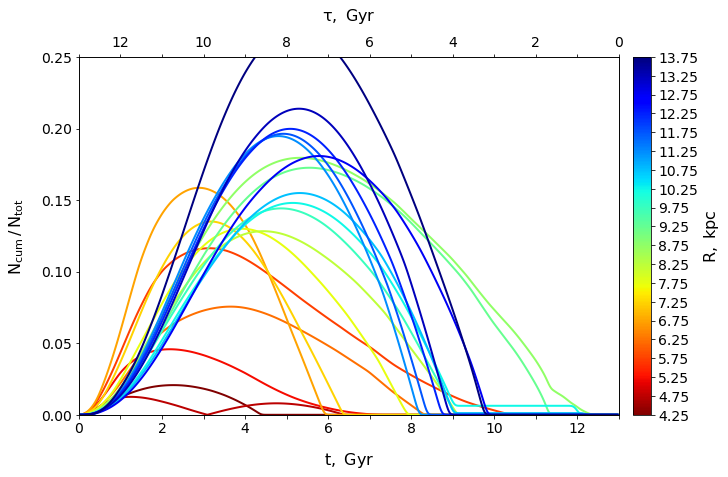

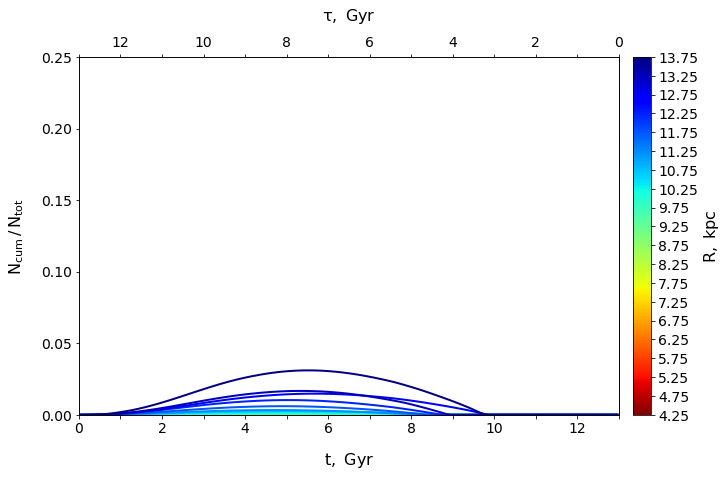

In [32]:
# Additional plots illustrating an impact of z-correction and warp on age distributions
# Plot 1. Ratio of CADFs no-z-correction/z-correction
# Plot 2. z-correction/z-correction+warp
# Summary: z-correction has a large impact on CADFs, and warp influences only slightly 
# and only in the outer disk.   


def plot_age_distributions_ratio(mode,arrayd1,arrayd2):
    # Plots CADF of the thin and thick disk 
    
    fig, ax = plt.subplots(figsize=(10,7))
    ax.set_xlim((0,tp))
    ax.set_ylim((0,0.25))
    ax.set_xticks(np.arange(tp+1))
    ax.set_xticklabels(['0','','2','','4','','6','','8','','10','','12',''])
    ax.set_xlabel('$\mathrm{t, \ Gyr}$',fontsize=fnt1,labelpad=15)
    ax.set_ylabel('$\mathrm{N_{cum} \, / \, N_{tot}}$',fontsize=fnt1,labelpad=15)
    axx = ax.twiny()
    axx.set_xticks(np.arange(tp+1))
    axx.set_xticklabels(['0','','2','','4','','6','','8','','10','','12',''][::-1])
    axx.set_xlabel(r'$\mathrm{\tau, \ Gyr}$',fontsize=fnt1,labelpad=15)
    fig.subplots_adjust(left=0.11,top=0.86,bottom=0.15,right=0.86)
    line_segments = LineCollection([list(zip(a.t,np.abs(arrayd2[i]-arrayd1[i]))) # /arrayd1[i]
                                    for i in np.arange(a.Rbins)],
                                    linewidths=2,cmap = mpl.cm.jet_r,
                                    norm = mpl.colors.Normalize(vmin=p.Rmin,vmax=p.Rmax))
    line_segments.set_array(a.R)
    im = ax.add_collection(line_segments)
    pos = ax.get_position()
    cax = fig.add_axes([pos.x0+pos.width+0.02,pos.y0,0.025,pos.height])
    cbar = fig.colorbar(im,cax=cax,orientation='vertical')
    cbar.set_ticks(a.R)
    cbar.set_label('$\mathrm{R, \ kpc}$',fontsize=fnt1)
    plt.show()
    fig.savefig(os.path.join(a.T['ageplt'],'CAge(nw)_rc_dr_'+mode+'_iter'+str(n_iter)+'.pdf'))

    
plot_age_distributions_ratio('model+zw2model',Age_dist_d[0],Age_dist_d[1])
plot_age_distributions_ratio('model+zw+warp2model+zw',Age_dist_d[1],Age_dist_d[2])



## Step 3. New AMR from CMDF and CADF

In [33]:

# Thin disk
AMRd_from_data = []
name_end = ['','_zw','_zw_warp']

for i in range(3):
    AMRd_from_data.append(np.zeros((a.Rbins,a.jd)))
    for k in range(a.Rbins):
        AMRd_from_data[i][k] = amr.get_amr(FeH_bins_d[k],Ncum_deconv_d[k],a.t,Age_dist_d[i][k],a)
    
    hl = ''.join(('t[Gyr], [Fe/H] for R=',str(p.Rmin),'-',str(p.Rmax),
                  'kpc with a step of',str(p.dR),'kpc, warp model = ',warp_model))
    np.savetxt(os.path.join(a.T['mettab'],''.join(('AMRd_apogee_rc_dr16',name_end[i],'.txt'))),
               np.hstack((a.t.reshape(a.jd,1),AMRd_from_data[i].T)),header=hl)

# Thick disk
AMRt_from_data = amr.get_amr(FeH_bins_t,Ncum_deconv_t,a.t,Age_dist_t,a)
np.savetxt(os.path.join(a.T['mettab'],'AMRt_apogee_rc_dr16.txt'),
           np.stack((a.t[:a.jt],AMRt_from_data[:a.jt]),axis=-1),header='t[Gyr], [Fe/H]')        


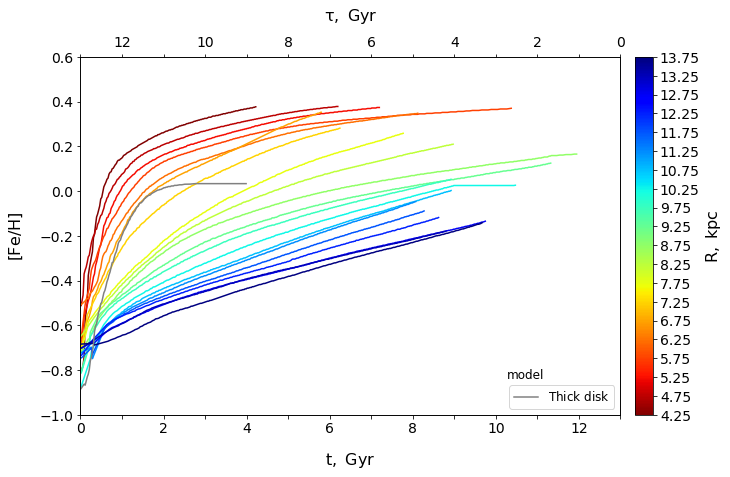

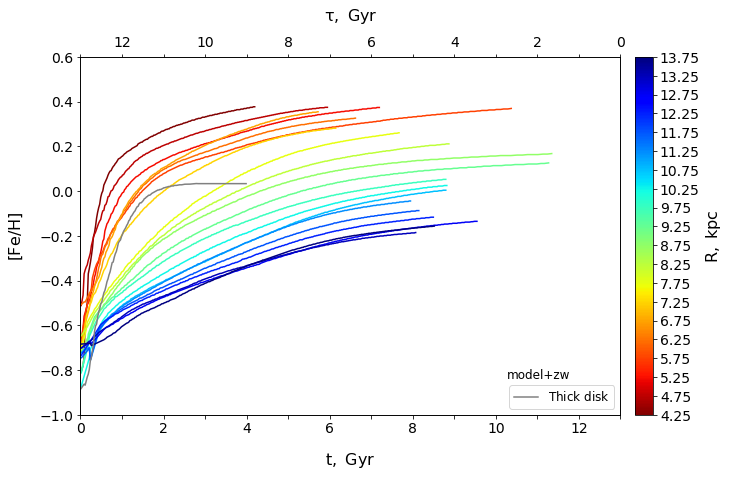

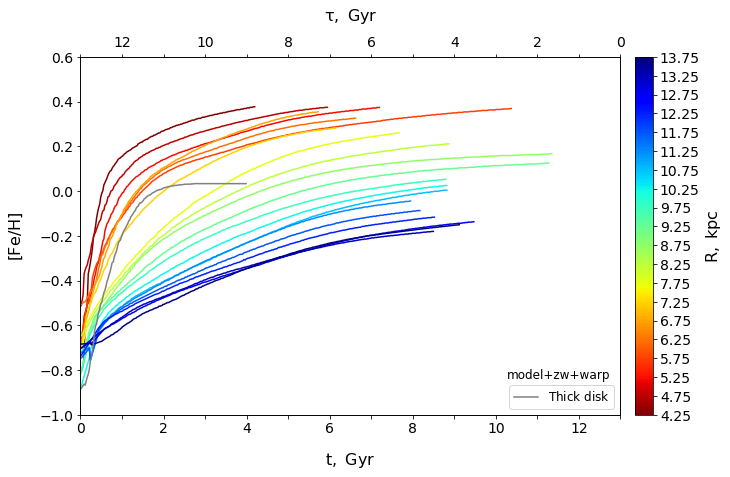

In [34]:
# Plots of the new AMR

def get_max_age_index(array):
    # Returns max time index of the updated AMR up to which the AMR can be used for fitting. 
    # A sub-array AMR[ind_age:] is filled with constant AMR[ind_age], which means that 
    # the routine for AMR reconstruction doesn't have enough data to get the AMR shape there 
    # (because some ages are not present in RC sample, see the age distribution plots above). 
    
    ind_age = []
    age_max = 12  # Gyr, max age up to which use AMR for fitting, 
                  # regardless of the derived AMR shape 
    for i in range(a.Rbins):
        d_array = np.diff(array[i])
        index = np.where(np.abs(d_array)>1e-3)[0][-1]
        if index > int(age_max//tr):
            ind_age.append(int(age_max//tr))
        else:
            ind_age.append(index)
    return ind_age


def plot_amr(mode,amrd_data,ia,**kwargs):
    # Plots the reconstructed AMR (thin and thick disk) 
   
    fig, ax = plt.subplots(figsize=(10,7))
    ax.set_xlim((0,tp))
    ax.set_ylim((-1.0,0.6))
    ax.set_xticks(np.arange(tp+1))
    ax.set_xticklabels(['0','','2','','4','','6','','8','','10','','12',''])
    ax.set_xlabel('$\mathrm{t, \ Gyr}$',fontsize=fnt1,labelpad=15)
    ax.set_ylabel('$\mathrm{[Fe/H]}$',fontsize=fnt1,labelpad=15)
    axx = ax.twiny()
    axx.set_xticks(np.arange(tp+1))
    axx.set_xticklabels(['0','','2','','4','','6','','8','','10','','12',''][::-1])
    axx.set_xlabel(r'$\mathrm{\tau, \ Gyr}$',fontsize=fnt1,labelpad=15)
    fig.subplots_adjust(left=0.11,top=0.86,bottom=0.15,right=0.86)

    line_segments1 = LineCollection([list(zip(a.t[:ia[i]],amrd_data[i][:ia[i]])) for i in np.arange(a.Rbins)],
                                     linewidths=1.5,cmap = mpl.cm.jet_r,
                                     norm = mpl.colors.Normalize(vmin=p.Rmin,vmax=p.Rmax))   
    line_segments1.set_array(a.R)
    im = ax.add_collection(line_segments1)
    ax.plot(a.t[:a.jt],AMRt_from_data[:a.jt],lw=1.5,c='grey',label='$\mathrm{Thick \ disk}$')
    ax.text(0.79,0.1,mode,fontsize=12,transform=ax.transAxes)  
    ax.legend(loc=4,prop={'size':fnt2})
    pos = ax.get_position()
    cax = fig.add_axes([pos.x0+pos.width+0.02,pos.y0,0.025,pos.height])
    cbar = fig.colorbar(im,cax=cax,orientation='vertical')
    cbar.set_ticks(a.R)
    cbar.set_label('$\mathrm{R, \ kpc}$',fontsize=fnt1)
    plt.show()
    if 'name' in kwargs:
        fig.savefig(os.path.join(a.T['metplt'],
                                 'AMR_apogee-rc-dr16_dt_'+mode+'_iter'+str(n_iter)+'_'+kwargs['name']+'.png'))
    else:    
        fig.savefig(os.path.join(a.T['metplt'],'AMR_apogee-rc-dr16_dt_'+mode+'_iter'+str(n_iter)+'.png'))


ia = [] 
for i in range(3):
    ia.append(get_max_age_index(AMRd_from_data[i]))
    plot_amr(modes[i],AMRd_from_data[i],ia[i],name='raw')

